# Real Time Driver Drowsiness Detection Using Machine Learning and Deep Learning Techniques

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# Set root path
root_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/'

## 3. EDA on Extracted Features

In [ ]:
# Convert data to dataframe
features_path = root_path + 'facial_features.csv'
df_features = pd.read_csv(features_path)
df_features.head()

,Subject ID,Category,EAR_mean,MAR,MER,Pupil_Dist_mean
0,A0001.png,Drowsy,0.325269,0.986342,3.032390,7.232155
1,A0006.png,Drowsy,0.388564,1.034512,2.662401,7.835448
2,A0012.png,Drowsy,0.356074,1.005553,2.823999,7.863683
3,A0018.png,Drowsy,0.332883,1.041447,3.128570,7.185532
4,A0024.png,Drowsy,0.343422,1.036147,3.017120,7.368369


In [ ]:
# Shape of dataframe
df_features.shape

(12194, 6)

In [ ]:
# Drop unnecessary columns
df_features = df_features.drop(columns=['Subject ID'])

In [ ]:
# Map categorical labels
label_map = {'Drowsy': 1, 'Non Drowsy': 0}
df_features['Category'] = df_features['Category'].map(label_map)

In [ ]:
# Check data types
df_features.dtypes

,0
Category,int64
EAR_mean,float64
MAR,float64
MER,float64
Pupil_Dist_mean,float64


In [ ]:
# Check for null values
df_features.isnull().sum()

,0
Category,0
EAR_mean,0
MAR,0
MER,0
Pupil_Dist_mean,0


In [ ]:
# Describe data
df_features.describe()

,Category,EAR_mean,MAR,MER,Pupil_Dist_mean
count,12194.000000,12194.000000,12194.000000,12194.000000,12194.000000
mean,0.503444,0.341127,0.945632,2.889885,7.723879
std,0.500009,0.062054,0.100320,0.728559,1.035282
min,0.000000,0.184693,0.630514,1.242154,4.005153
25%,0.000000,0.309416,0.878034,2.347736,6.982068
50%,1.000000,0.337076,0.940277,2.870861,7.744597
75%,1.000000,0.374662,0.990301,3.196733,8.429684
max,1.000000,0.553575,1.868061,5.943455,12.027053


In [ ]:
# Standardise data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ["EAR_mean", "MAR", "MER", "Pupil_Dist_mean"]

# Make a copy of df_features
df_features_scaled = df_features.copy()
df_features_scaled[features] = scaler.fit_transform(df_features_scaled[features])

#### Box plot of facial features by category:

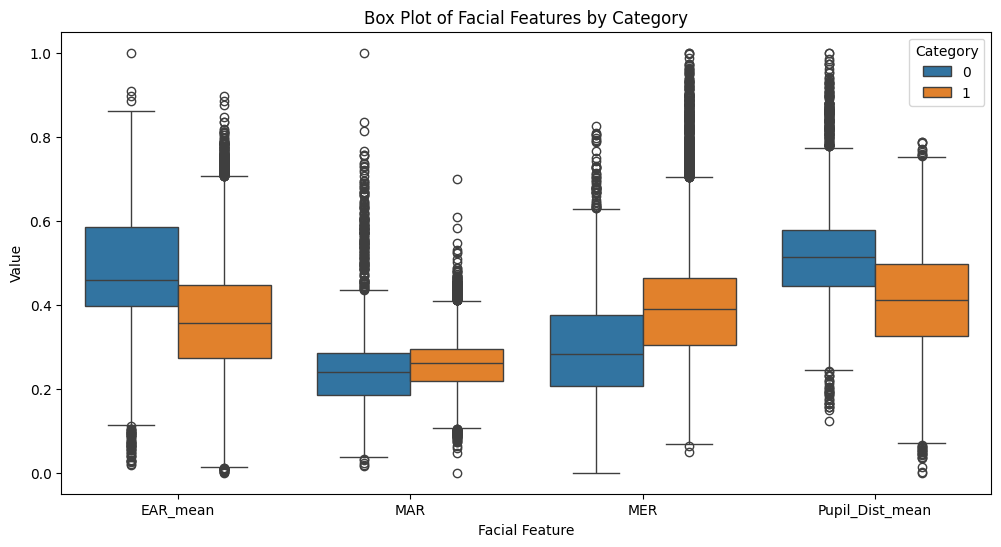

In [ ]:
df_melted = df_features_scaled.melt(id_vars=["Category"], value_vars=features, var_name="Feature", value_name="Value")

# Create a single box plot for all features by category
plt.figure(figsize=(12, 6))
sns.boxplot(x="Feature", y="Value", hue="Category", data=df_melted)
plt.title("Box Plot of Facial Features by Category")
plt.xlabel("Facial Feature")
plt.ylabel("Value")
plt.legend(title="Category")
plt.show()

**Some observations from the box plot above:**

1. EAR_mean (Eye Aspect Ratio):

  * Category 0 (alert) has a higher median compared to Category 1 (drowsy).
  * The interquartile range (IQR) for Category 0 is wider, suggesting more variability in eye aspect ratios for alert individuals.
  * Category 1 has a lower median, indicating a decrease in eye openness, which aligns with drowsiness.

2. MAR (Mouth Aspect Ratio):

  * The median MAR is slightly higher in Category 1 compared to Category 0.
  * This suggests that drowsy individuals may tend to have their mouths more open, which could be a sign of yawning.

3. MER (Mouth-Eye Ratio):

  * The median for Category 1 is noticeably higher than Category 0.
  * This suggests that in drowsy states, the mouth aspect ratio increases more than the eye aspect ratio, which could indicate yawning or relaxed facial muscles.

4. Pupil_Dist_mean (Pupil Distance Mean):

  * Category 0 has a higher median compared to Category 1.
  * This could indicate that alert individuals tend to focus more, leading to larger pupil distances, whereas drowsy individuals may have relaxed or unfocused gaze, reducing pupil distance.

General Observations:
  * Clear separation between alert (0) and drowsy (1) states in EAR_mean and Pupil_Dist_mean, making them strong indicators for detecting drowsiness.
  * Increased variability in drowsy states (Category 1) for MAR and MER, suggesting inconsistent facial movements (yawning, eye closure, etc.).
  * Presence of outliers, especially in MER and MAR, indicating some extreme values that might be due to occasional large mouth openings or unusual eye movements.


#### Pair plots and correlation heatmap

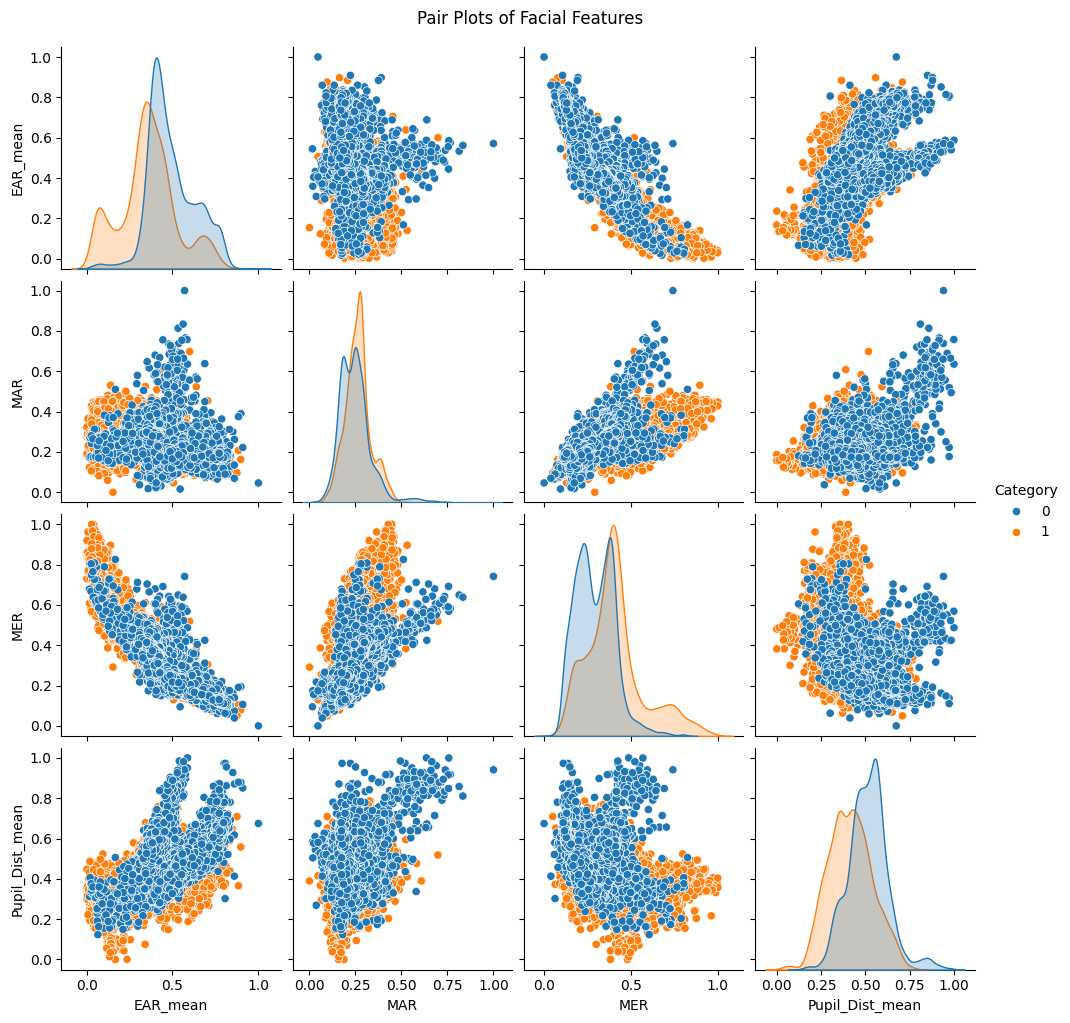

In [ ]:
# Pair plots
sns.pairplot(df_features_scaled, hue='Category')
plt.suptitle('Pair Plots of Facial Features', y=1.02)
plt.show()

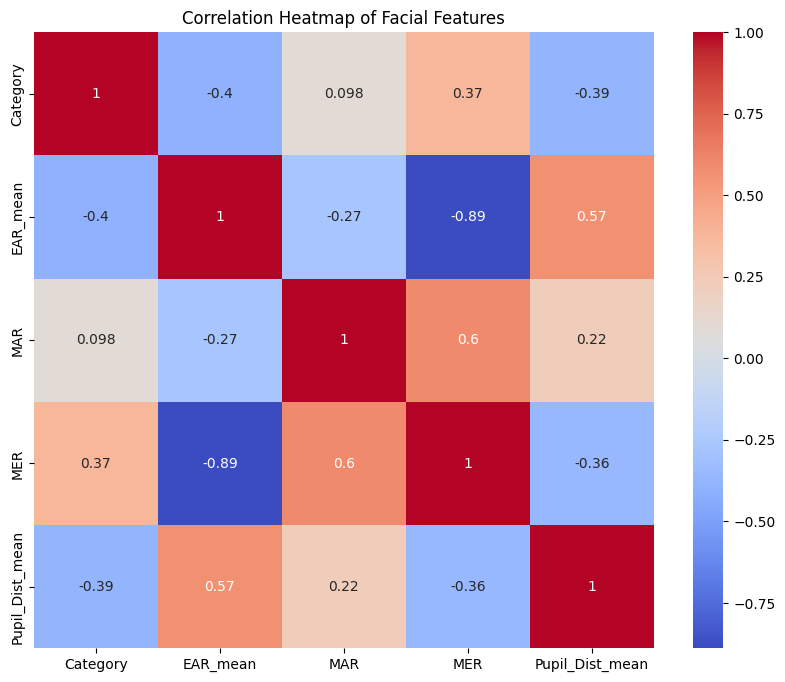

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_features_scaled.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Facial Features")
plt.show()

**Summary of Insights from Pair Plot & Correlation Heatmap**

1. Key Features for Drowsiness Detection:

  * EAR_mean (Eye Aspect Ratio) and Pupil_Dist_mean (Mean Pupil Distance) provide the most distinct separation between alert (Category 0) and drowsy (Category 1) states.
  * MER (Mouth-Eye Ratio) and MAR (Mouth Aspect Ratio) contribute to classification but show more overlap between categories.

2. Strongest Correlations:

  * EAR_mean & MER (-0.89): Strong negative correlation — eye closure increases mouth engagement.
  * MAR & MER (0.6): Positive correlation — both mouth-related features tend to increase together.
  * Pupil_Dist_mean & EAR_mean (0.57): Moderate positive correlation — alert individuals have higher pupil distance.

3. Category Relationship:

  * EAR_mean (-0.4): Moderately negative correlation with drowsiness, confirming eye closure as a key indicator.
  * MER (0.37): Positive correlation with drowsiness—mouth engagement increases when drowsy.
  * Pupil_Dist_mean (-0.39): Negative correlation with drowsiness, suggesting relaxed gaze in drowsy individuals.

## 4. Train Machine Learning Models

In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report, confusion_matrix

In [ ]:
# Define features and target variable
X = df_features.drop(columns=['Category'])
y = df_features['Category']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Shape of train and test dataset
X_train.shape, X_test.shape

((9755, 4), (2439, 4))

In [ ]:
# Standardise features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Define functions:

In [ ]:
# Define function to evaluate classification model

def evaluate_classification_model(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a classification model, plotting the confusion matrix, ROC-AUC curve, and Precision-Recall curve.

    Parameters:
    - model: The classification model to be trained and evaluated.
    - X_train: Training feature set.
    - y_train: Training target labels.
    - X_test: Test feature set.
    - y_test: Test target labels.
    """

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    # Compute classification report
    class_report = classification_report(y_test, y_pred_test)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Non-drowsy", "Drowsy"], yticklabels=["Non-drowsy", "Drowsy"], ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title('Confusion Matrix')

    # ROC-AUC Curve
    axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC-AUC Curve')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.0])
    axes[1].legend()

    # Precision-Recall Curve
    axes[2].plot(recall, precision, color='blue', lw=2, label=f'Average precision = {ap:.2f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.0])
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Display results
    print(f"Accuracy score (train): {accuracy_train:.2f}")
    print(f"Accuracy score (test): {accuracy_test:.2f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    print("\nClassification Report:\n", class_report)

#### Baseline Classification Models

Logistic Regression:

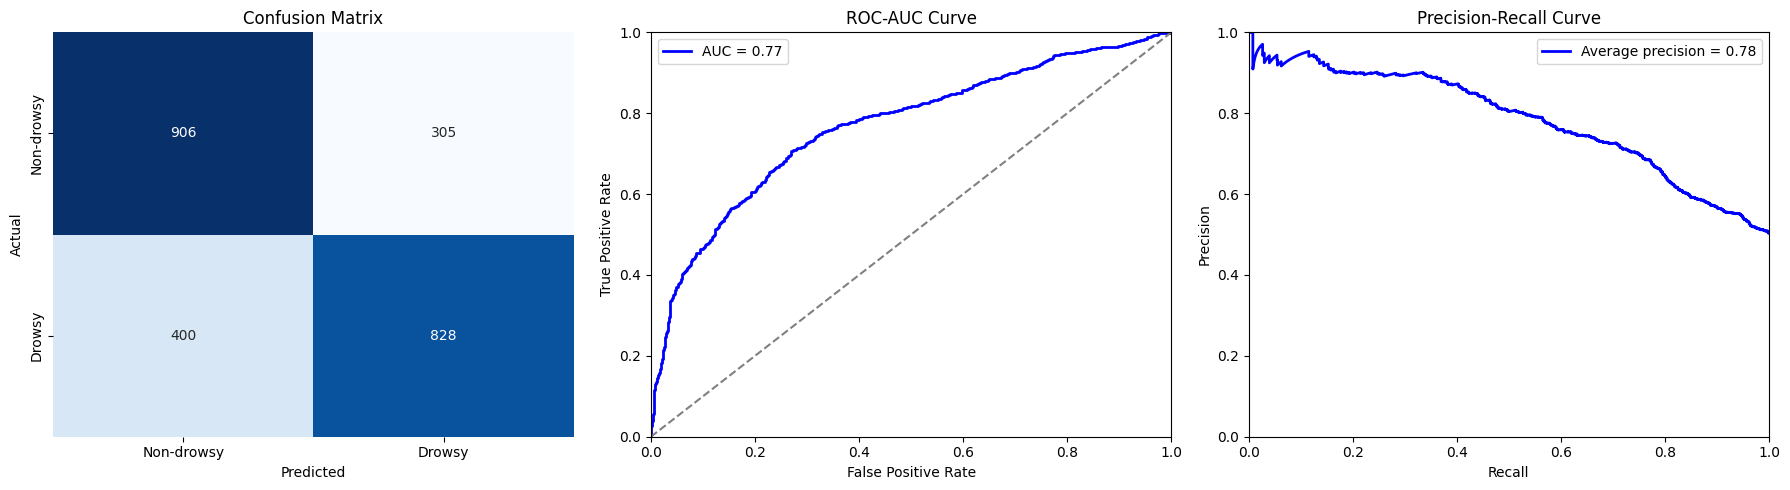

Accuracy score (train): 0.72
Accuracy score (test): 0.71
Cross-Validation Accuracy: 0.72 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72      1211
           1       0.73      0.67      0.70      1228

    accuracy                           0.71      2439
   macro avg       0.71      0.71      0.71      2439
weighted avg       0.71      0.71      0.71      2439



In [ ]:
# Initialise the model
model = LogisticRegression()

# Evaluate the model
evaluate_classification_model(model, X_train, y_train, X_test, y_test)

SVM:

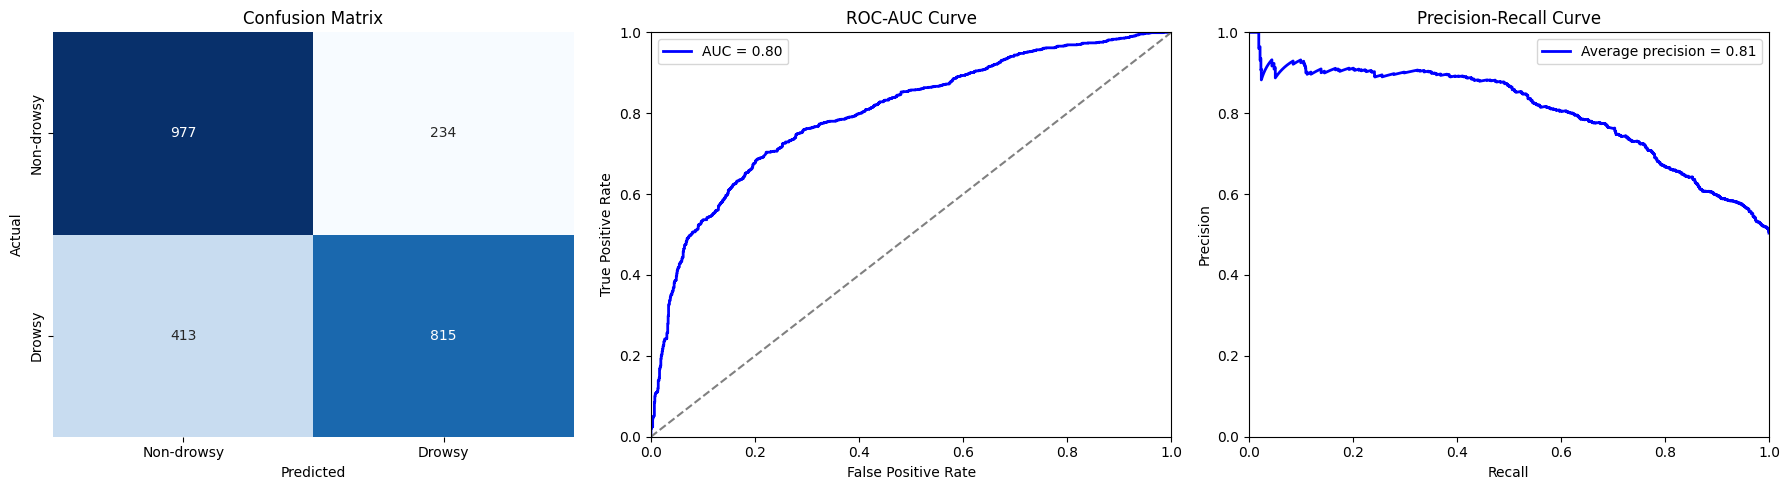

Accuracy score (train): 0.73
Accuracy score (test): 0.73
Cross-Validation Accuracy: 0.73 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75      1211
           1       0.78      0.66      0.72      1228

    accuracy                           0.73      2439
   macro avg       0.74      0.74      0.73      2439
weighted avg       0.74      0.73      0.73      2439



In [ ]:
# Initialise the model
model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# Evaluate the model
evaluate_classification_model(model, X_train, y_train, X_test, y_test)

Random Forest:

In [ ]:
# Define function to evaluate classification model with GridSearchCV

def evaluate_classification_model_GridSearch(model, param_grid, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a classification model, plotting the confusion matrix, ROC-AUC curve, and Precision-Recall curve.

    Parameters:
    - model: The classification model to be trained and evaluated.
    - param_grid: Hyperparameter grid for GridSearchCV.
    - X_train: Training feature set.
    - y_train: Training target labels.
    - X_test: Test feature set.
    - y_test: Test target labels.
    """

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_rf = grid_search.best_estimator_

    # Make predictions
    y_pred_train = best_rf.predict(X_train)
    y_pred_test = best_rf.predict(X_test)
    y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring='accuracy')

    # Compute classification report
    class_report = classification_report(y_test, y_pred_test)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap = average_precision_score(y_test, y_pred_proba)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Non-drowsy", "Drowsy"], yticklabels=["Non-drowsy", "Drowsy"], ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title('Confusion Matrix')

    # ROC-AUC Curve
    axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC-AUC Curve')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.0])
    axes[1].legend()

    # Precision-Recall Curve
    axes[2].plot(recall, precision, color='blue', lw=2, label=f'Average precision = {ap:.2f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.0])
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Display results
    print(f"Best parameter: {grid_search.best_params_}")
    print(f"Accuracy score (train): {accuracy_train:.2f}")
    print(f"Accuracy score (test): {accuracy_test:.2f}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    print("\nClassification Report:\n", class_report)

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 75, 100],
    'max_depth': [5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20],
    'class_weight': ['balanced']
}

Fitting 5 folds for each of 81 candidates, totalling 405 fits


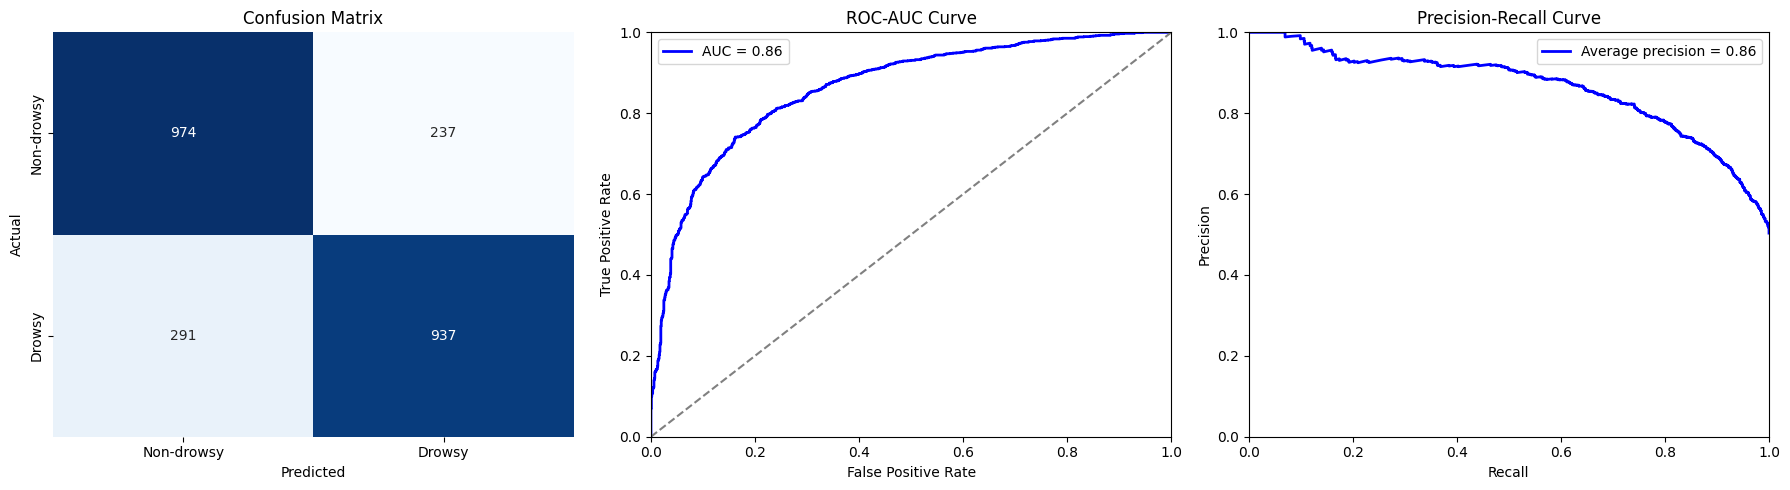

Best parameter: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy score (train): 0.84
Accuracy score (test): 0.78
Cross-Validation Accuracy: 0.79 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.79      1211
           1       0.80      0.76      0.78      1228

    accuracy                           0.78      2439
   macro avg       0.78      0.78      0.78      2439
weighted avg       0.78      0.78      0.78      2439



In [ ]:
# Initialise the model
model = RandomForestClassifier(random_state=42)

# Evaluate the model
evaluate_classification_model_GridSearch(model, param_grid_rf, X_train, y_train, X_test, y_test)

XGBoost:

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 75, 100],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

Fitting 5 folds for each of 81 candidates, totalling 405 fits


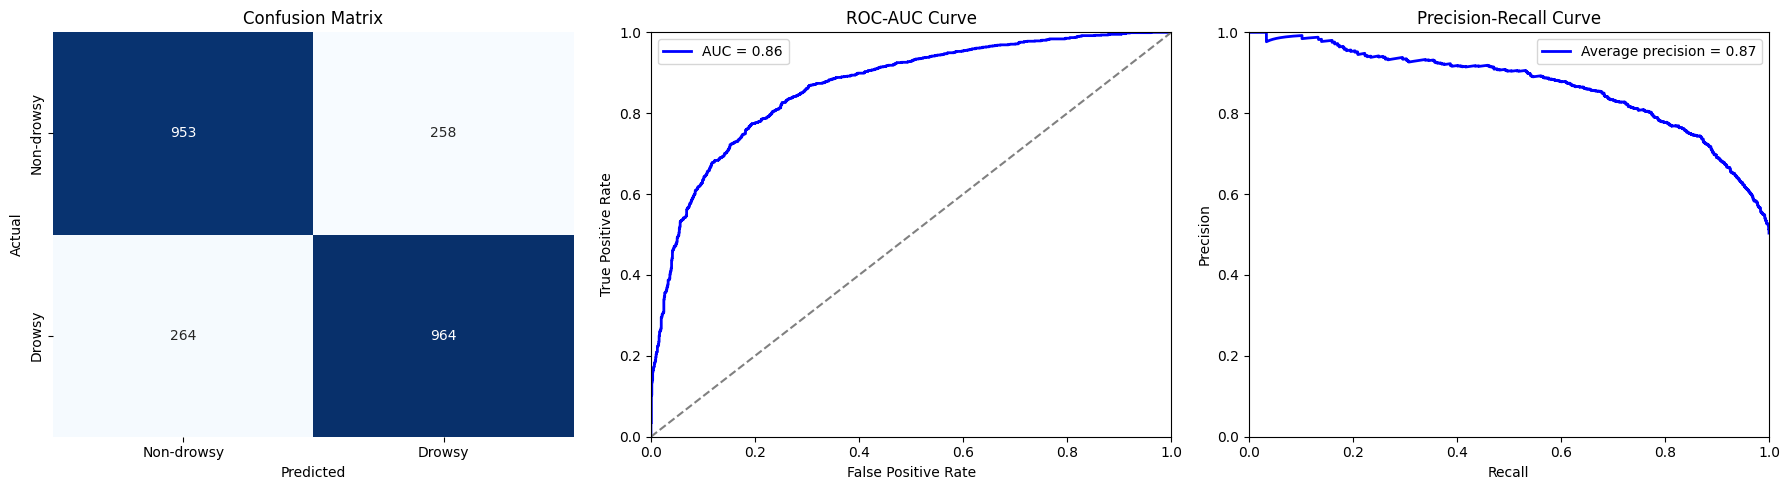

Best parameter: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 75, 'subsample': 0.8}
Accuracy score (train): 0.85
Accuracy score (test): 0.79
Cross-Validation Accuracy: 0.79 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79      1211
           1       0.79      0.79      0.79      1228

    accuracy                           0.79      2439
   macro avg       0.79      0.79      0.79      2439
weighted avg       0.79      0.79      0.79      2439



In [ ]:
# Initialise the model
model = XGBClassifier(random_state=42)

# Evaluate the model
evaluate_classification_model_GridSearch(model, param_grid_xgb, X_train, y_train, X_test, y_test)

#### Try Feature Engineering

Creating new interaction features:

In [ ]:
# Mouth Openness Score (Combination of MAR & MER)
df_features["Mouth_Openness"] = df_features["MAR"] + df_features["MER"]

# Mouth Eye Interaction Term (Multiplication of features)
df_features["Mouth_Eye_Interaction"] = df_features["MAR"] * df_features["EAR_mean"]

# Difference between MAR & MER (Captures variations in mouth movements)
df_features["Mouth_Difference"] = abs(df_features["MAR"] - df_features["MER"])

In [ ]:
# Define features and target variable
X_new = df_features.drop(columns=['Category'])
y_new = df_features['Category']

In [ ]:
# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Standardise features
X_train_new = scaler.fit_transform(X_train_new)
X_test_new = scaler.transform(X_test_new)

Retrain Logistic Regression:

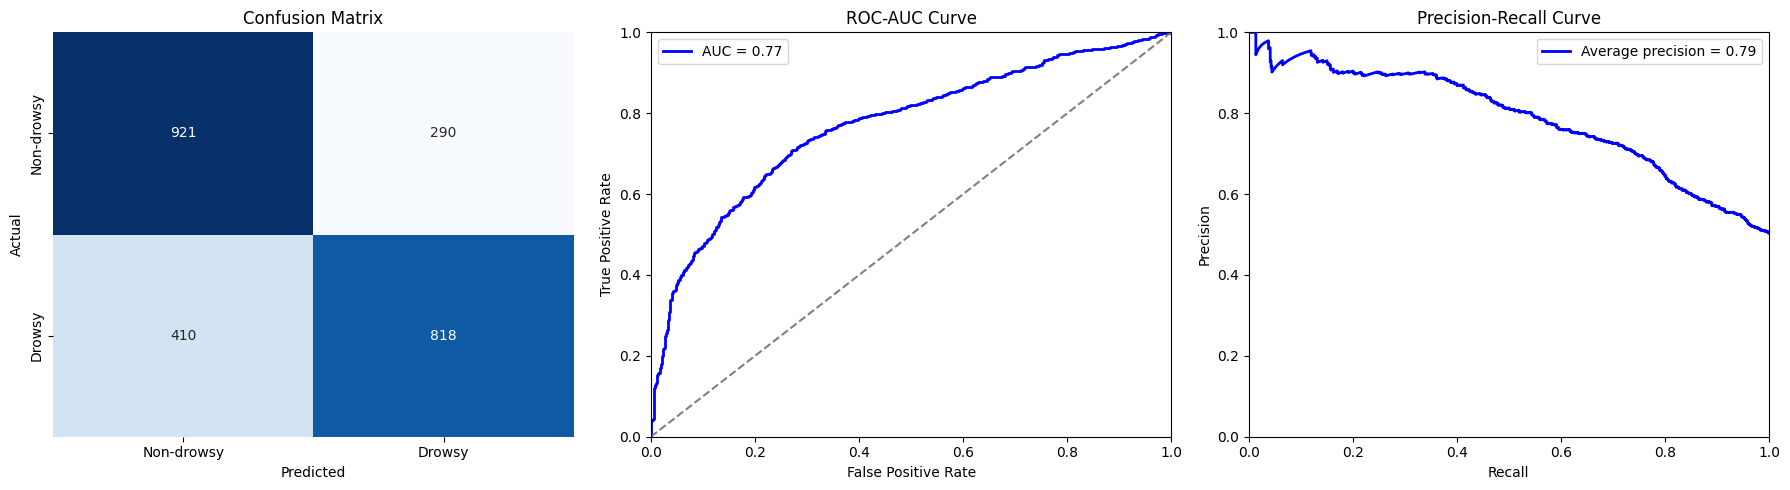

Accuracy score (train): 0.72
Accuracy score (test): 0.71
Cross-Validation Accuracy: 0.72 ± 0.00

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72      1211
           1       0.74      0.67      0.70      1228

    accuracy                           0.71      2439
   macro avg       0.72      0.71      0.71      2439
weighted avg       0.72      0.71      0.71      2439



In [ ]:
# Initialise the model
model = LogisticRegression()

# Evaluate the model
evaluate_classification_model(model, X_train_new, y_train_new, X_test_new, y_test_new)

Retrain SVM:

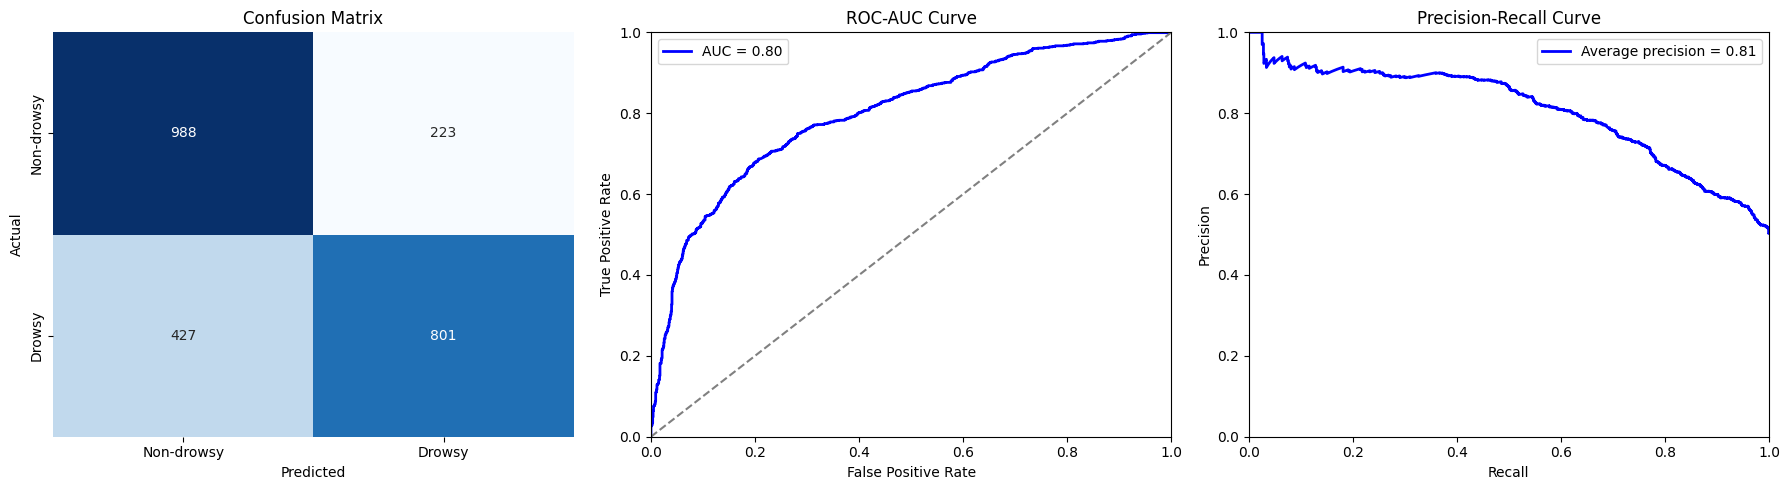

Accuracy score (train): 0.73
Accuracy score (test): 0.73
Cross-Validation Accuracy: 0.73 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.82      0.75      1211
           1       0.78      0.65      0.71      1228

    accuracy                           0.73      2439
   macro avg       0.74      0.73      0.73      2439
weighted avg       0.74      0.73      0.73      2439



In [ ]:
# Initialise the model
model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# Evaluate the model
evaluate_classification_model(model, X_train_new, y_train_new, X_test_new, y_test_new)

Retrain Random Forest:

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 75, 100],
    'max_depth': [5, 7, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20],
    'class_weight': ['balanced']
}

Fitting 5 folds for each of 81 candidates, totalling 405 fits


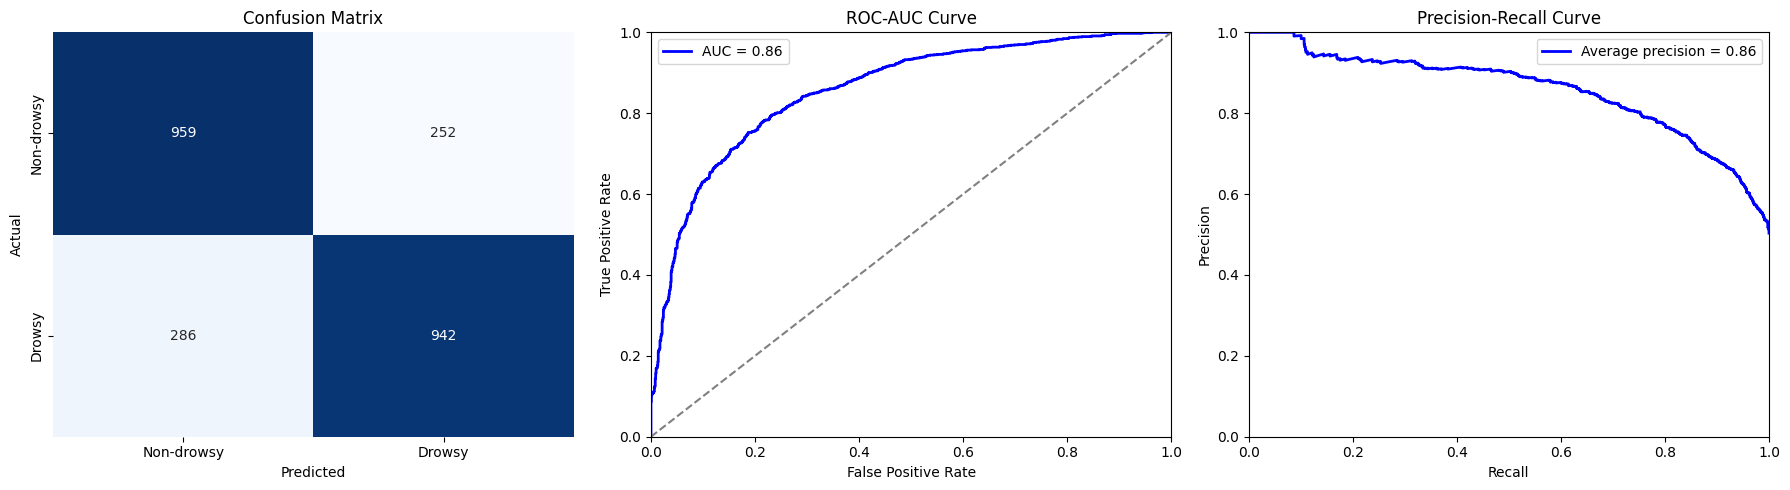

Best parameter: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy score (train): 0.83
Accuracy score (test): 0.78
Cross-Validation Accuracy: 0.79 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      1211
           1       0.79      0.77      0.78      1228

    accuracy                           0.78      2439
   macro avg       0.78      0.78      0.78      2439
weighted avg       0.78      0.78      0.78      2439



In [ ]:
# Initialise the model
model = RandomForestClassifier(random_state=42)

# Evaluate the model
evaluate_classification_model_GridSearch(model, param_grid_rf, X_train_new, y_train_new, X_test_new, y_test_new)

Retrain XGBoost:

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 75, 100],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

Fitting 5 folds for each of 81 candidates, totalling 405 fits


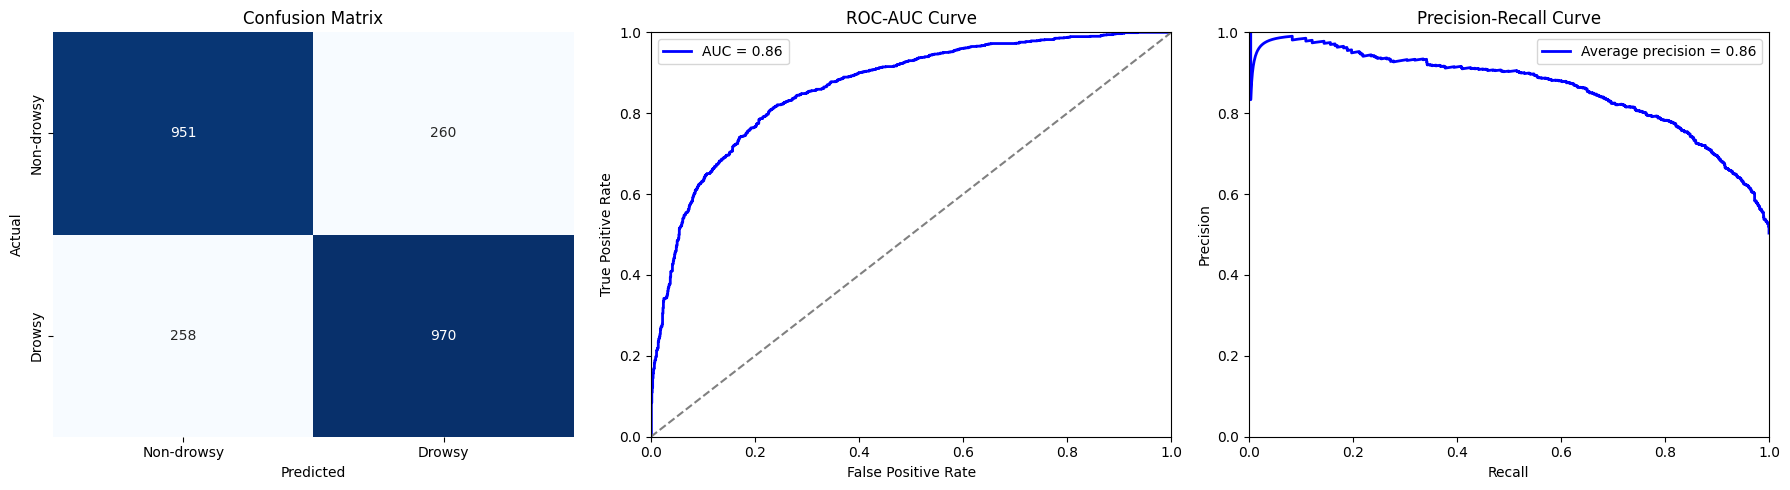

Best parameter: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Accuracy score (train): 0.86
Accuracy score (test): 0.79
Cross-Validation Accuracy: 0.79 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      1211
           1       0.79      0.79      0.79      1228

    accuracy                           0.79      2439
   macro avg       0.79      0.79      0.79      2439
weighted avg       0.79      0.79      0.79      2439



In [ ]:
# Initialise the model
model = XGBClassifier(random_state=42)

# Evaluate the model
evaluate_classification_model_GridSearch(model, param_grid_xgb, X_train_new, y_train_new, X_test_new, y_test_new)

#### Try Principle Component Analysis (PCA)

In [ ]:
# Import libraries
from sklearn.decomposition import PCA

In [ ]:
# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Apply PCA to reduce feature dimensions
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_new)
X_test_pca = pca.transform(X_test_new)

In [ ]:
# Check explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Sum of Explained Variance Ratio: {explained_variance_ratio.sum():.3f}")

Sum of Explained Variance Ratio: 1.000


Retrain Logistic Regression:

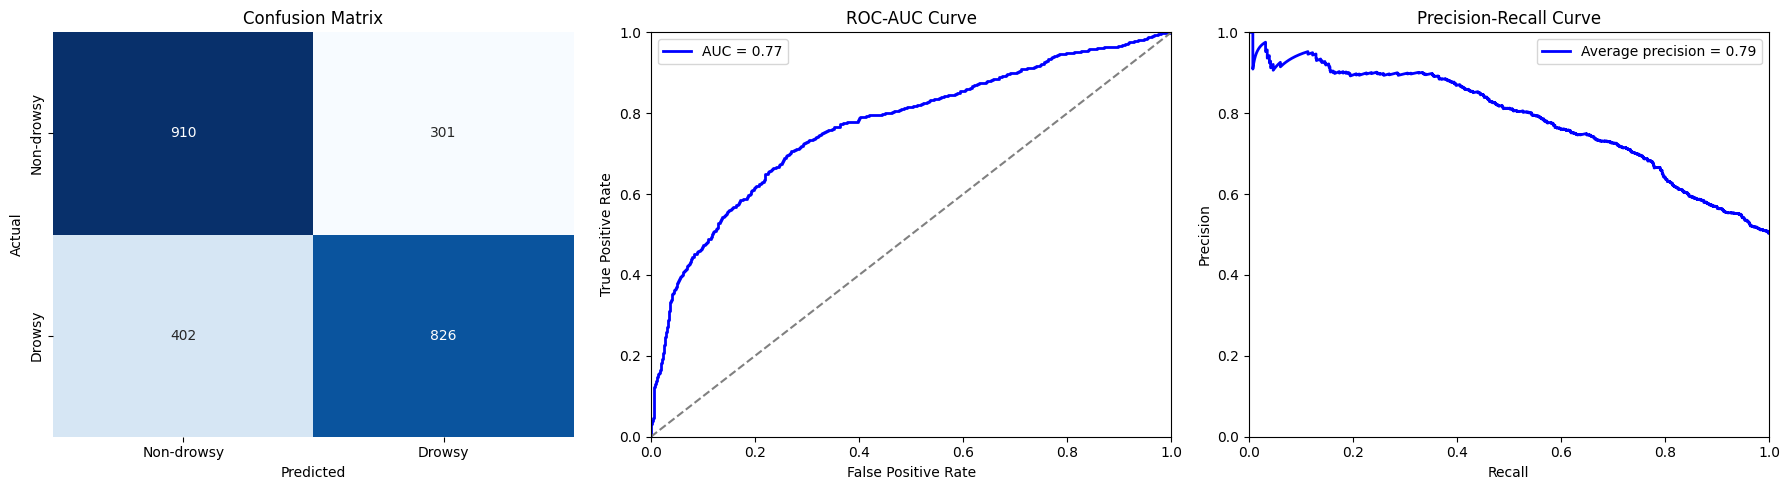

Accuracy score (train): 0.72
Accuracy score (test): 0.71
Cross-Validation Accuracy: 0.72 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72      1211
           1       0.73      0.67      0.70      1228

    accuracy                           0.71      2439
   macro avg       0.71      0.71      0.71      2439
weighted avg       0.71      0.71      0.71      2439



In [ ]:
# Initialise the model
model = LogisticRegression()

# Evaluate the model
evaluate_classification_model(model, X_train_pca, y_train_new, X_test_pca, y_test_new)

Retrain SVM:

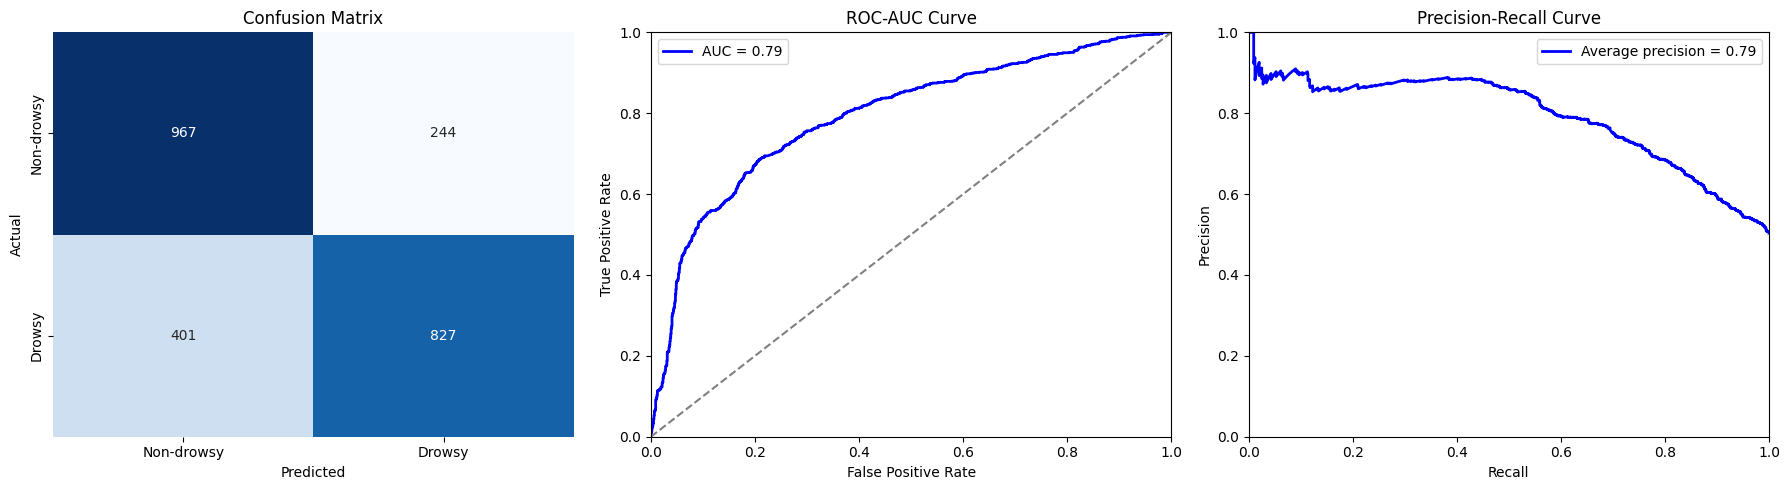

Accuracy score (train): 0.73
Accuracy score (test): 0.74
Cross-Validation Accuracy: 0.73 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.80      0.75      1211
           1       0.77      0.67      0.72      1228

    accuracy                           0.74      2439
   macro avg       0.74      0.74      0.73      2439
weighted avg       0.74      0.74      0.73      2439



In [ ]:
# Initialise the model
model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# Evaluate the model
evaluate_classification_model(model, X_train_pca, y_train_new, X_test_pca, y_test_new)

Retrain Random Forest:

Fitting 5 folds for each of 81 candidates, totalling 405 fits


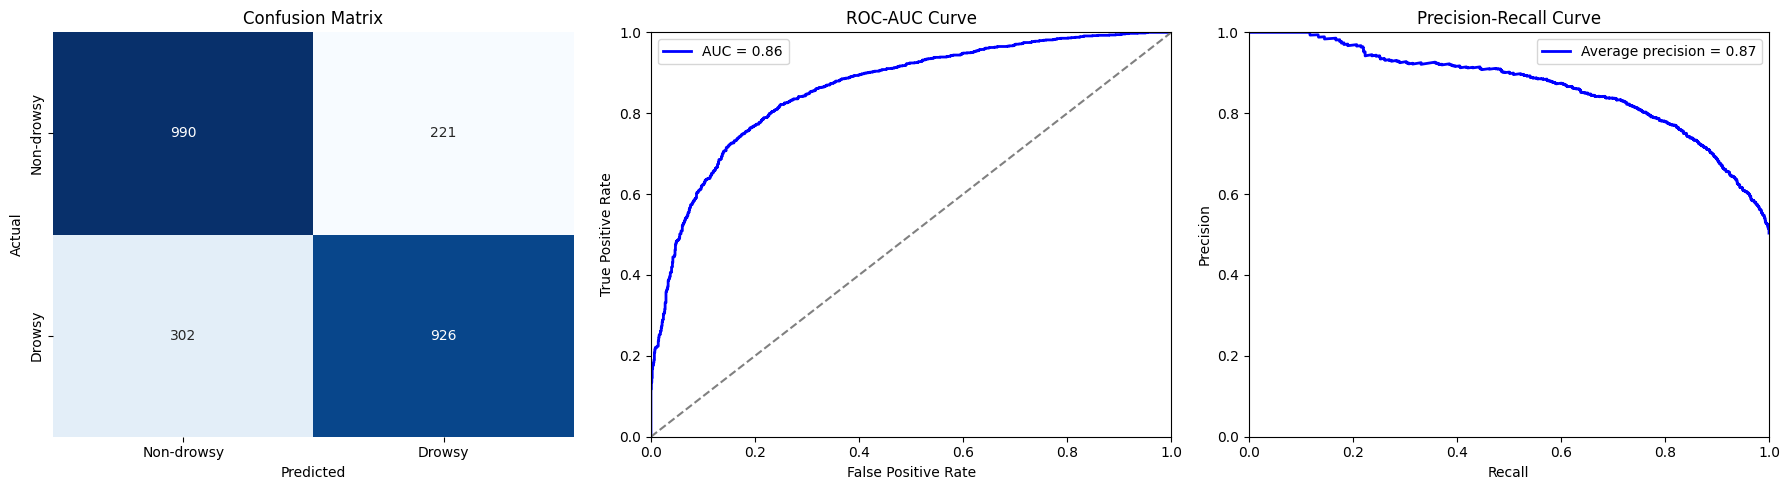

Best parameter: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy score (train): 0.84
Accuracy score (test): 0.79
Cross-Validation Accuracy: 0.78 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.79      1211
           1       0.81      0.75      0.78      1228

    accuracy                           0.79      2439
   macro avg       0.79      0.79      0.79      2439
weighted avg       0.79      0.79      0.79      2439



In [ ]:
# Initialise the model
model = RandomForestClassifier(random_state=42)

# Evaluate the model
evaluate_classification_model_GridSearch(model, param_grid_rf, X_train_pca, y_train_new, X_test_pca, y_test_new)

Retrain XGBoost:

In [ ]:
# Apply PCA to reduce feature dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_new)
X_test_pca = pca.transform(X_test_new)

In [ ]:
# Check explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Sum of Explained Variance Ratio: {explained_variance_ratio.sum():.3f}")

Sum of Explained Variance Ratio: 0.995


Fitting 5 folds for each of 81 candidates, totalling 405 fits


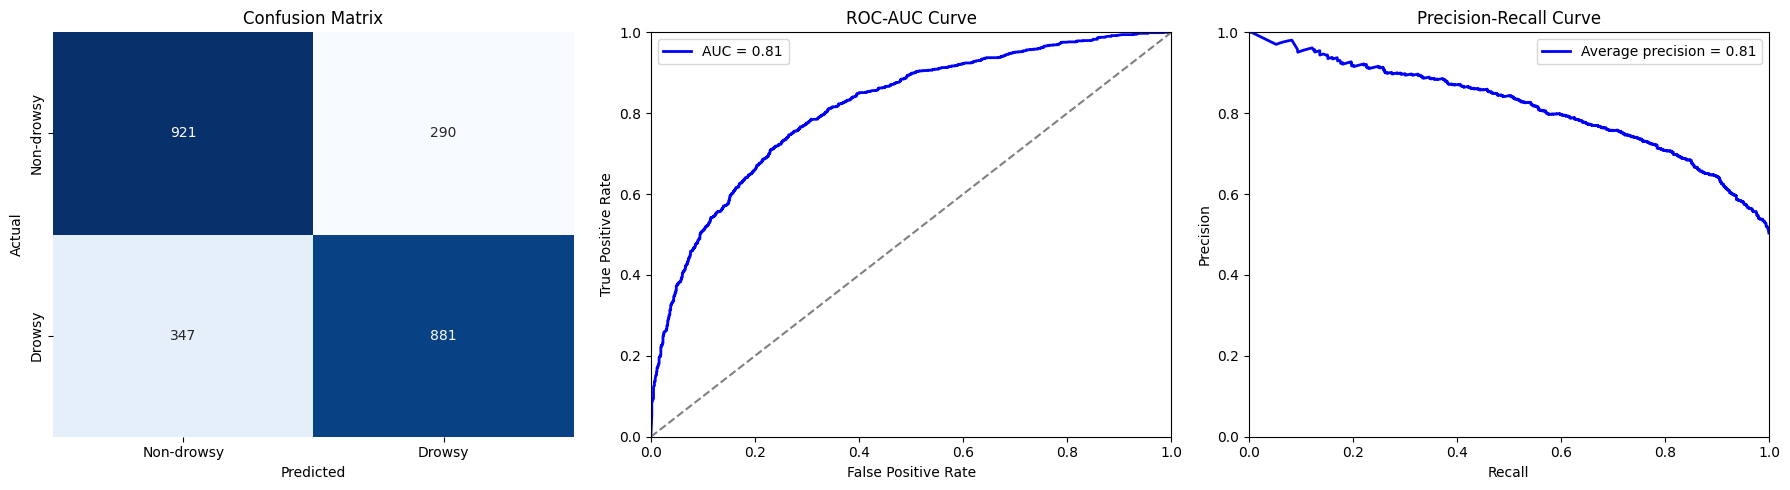

Best parameter: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.6}
Accuracy score (train): 0.79
Accuracy score (test): 0.74
Cross-Validation Accuracy: 0.74 ± 0.01

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.74      1211
           1       0.75      0.72      0.73      1228

    accuracy                           0.74      2439
   macro avg       0.74      0.74      0.74      2439
weighted avg       0.74      0.74      0.74      2439



In [ ]:
# Initialise the model
model = XGBClassifier(random_state=42)

# Evaluate the model
evaluate_classification_model_GridSearch(model, param_grid_xgb, X_train_pca, y_train_new, X_test_pca, y_test_new)

# 5. Train CNN + LSTM Model

In [ ]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, Flatten,
    BatchNormalization, LSTM, Dense, Dropout
)
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, classification_report, confusion_matrix
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

Load saved sequences:

In [ ]:
# Define function to load saved sequences
def load_saved_sequences(split_type):

  # Choose subject-wise or random split
  split_type = split_type

  # Define path to file
  file_path = f"/content/drive/MyDrive/Colab Notebooks/Capstone Project/Sequences/{split_type}_split.npz"

  # Load saved sequences
  data = np.load(file_path)
  X_train = data["X_train"]
  X_test = data["X_test"]
  y_train = data["y_train"]
  y_test = data["y_test"]

  print(f"✅ Loaded {split_type} split")
  print("X_train shape:", X_train.shape)
  print("y_train shape:", y_train.shape)
  print("X_test shape:", X_test.shape)
  print("y_test shape:", y_test.shape)

  return X_train, X_test, y_train, y_test

Model Architecture:

In [ ]:
model = Sequential()

# 1st CNN layer
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
                          input_shape=(30, 96, 96, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.25)))

# 2nd CNN layer
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.25)))

# 3rd CNN layer
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.25)))

# Flatten frame-wise features
model.add(TimeDistributed(Flatten()))

# LSTM to model temporal dependencies
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))

# Fully connected layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 30, 96, 96, 16)      │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 48, 48, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 48, 48, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 30, 48, 48, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 30, 48, 48, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 30, 24, 24, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 30, 24, 24, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 30, 24, 24, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 30, 24, 24, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 30, 12, 12, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 30, 12, 12, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 30, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 30, 9216)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │       1,183,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,208,705 (4.61 MB)

 Trainable params: 1,208,481 (4.61 MB)

 Non-trainable params: 224 (896.00 B)

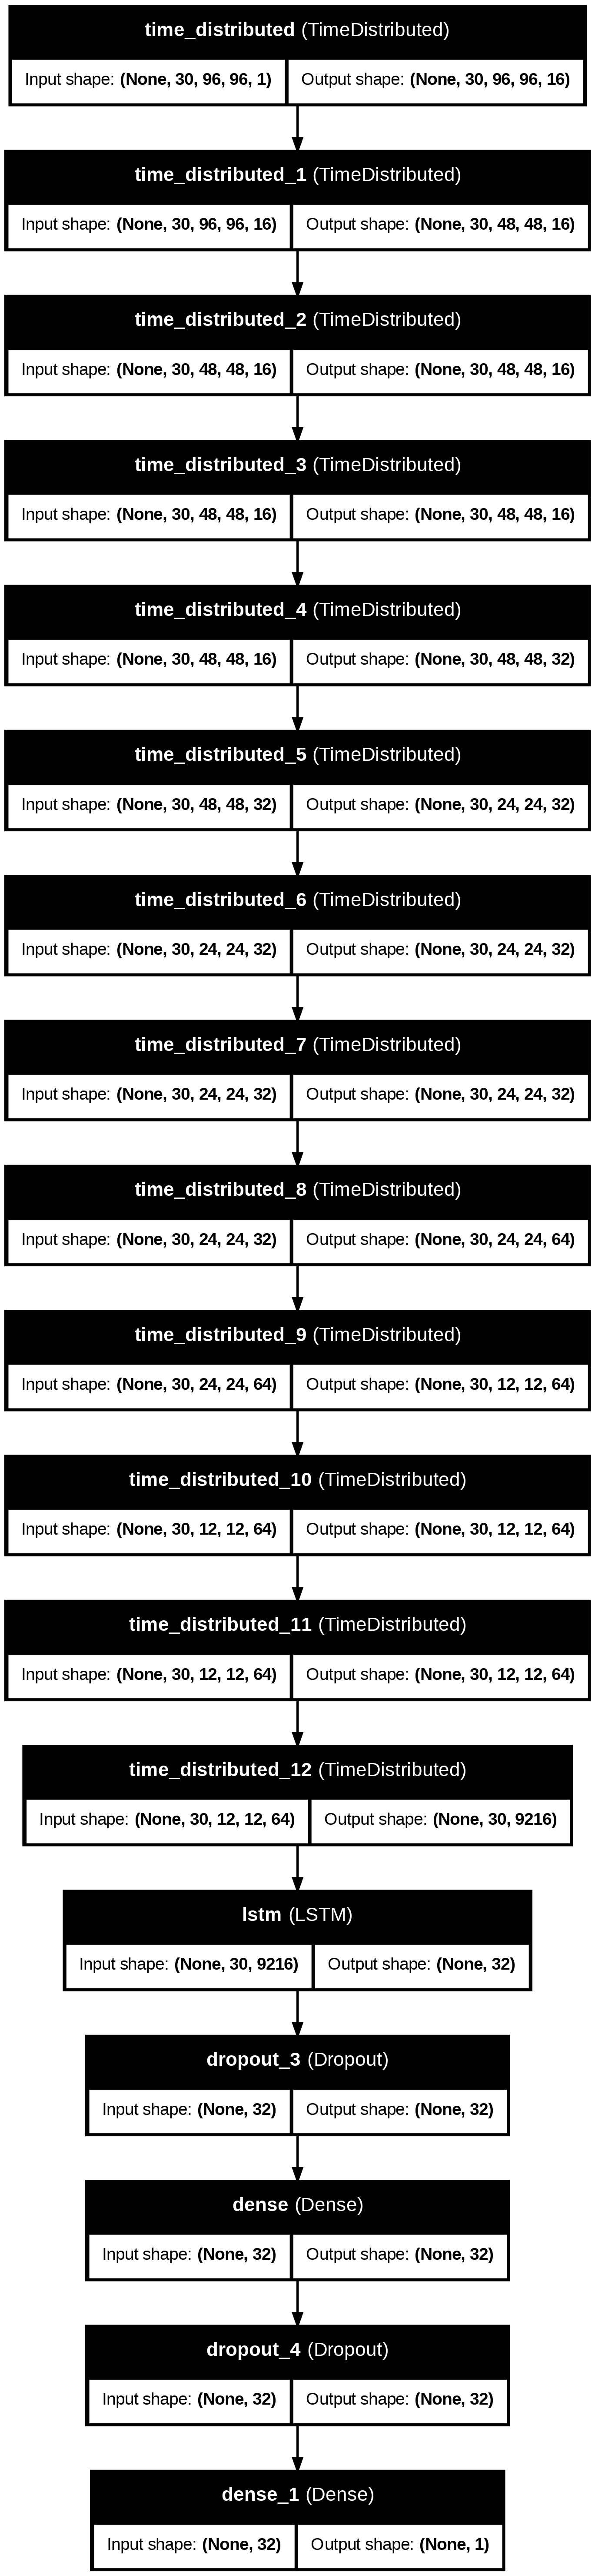

In [ ]:
# Plot the model
from tensorflow.keras.utils import plot_model

# Plot and save the model architecture to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Train CNN + LSTM Model (Random Split):

In [ ]:
# Define function to train and evaluate the model
def train_and_evaluate(model, X_train, X_test, y_train, y_test, title, best_model_name):

    # Define callbacks inside the function
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Capstone Project/" + best_model_name
    model_ckpt = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=20, batch_size=32, verbose=1,
                        callbacks=[early_stop, model_ckpt])

    # Evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{title} - Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()  # Threshold at 0.5
    y_true_labels = y_test.flatten()
    y_score = y_pred.flatten()

    # Compute classification report
    class_report = classification_report(y_true_labels, y_pred_labels)

    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # Compute ROC-AUC score
    roc_auc = roc_auc_score(y_true_labels, y_score)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true_labels, y_score)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true_labels, y_score)
    ap = average_precision_score(y_true_labels, y_score)

    # Plot Loss & Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim([0, 20])
    plt.ylim([0, 0.5])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title} - Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xlim([0, 20])
    plt.ylim([0.5, 1])
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Combined Confusion, ROC, PR plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Drowsy', 'Drowsy'], yticklabels=['Non-Drowsy', 'Drowsy'], ax=axs[0])
    axs[0].set_title("Confusion Matrix")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    axs[1].plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1].set_title("ROC Curve")
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.0])
    axs[1].legend()

    axs[2].plot(recall, precision, color='blue', lw=2, label=f'Average precision = {ap:.2f}')
    axs[2].set_title("Precision-Recall Curve")
    axs[2].set_xlabel("Recall")
    axs[2].set_ylabel("Precision")
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.0])
    axs[2].legend()

    plt.tight_layout()
    plt.suptitle(title, fontsize=14, y=1.05)
    plt.show()

    # Display results
    print("\nClassification Report:\n", class_report)

In [ ]:
# Train the model based on random split
X_train, X_test, y_train, y_test = load_saved_sequences(split_type="random")

✅ Loaded random split
X_train shape: (8555, 30, 96, 96, 1)
y_train shape: (8555,)
X_test shape: (2139, 30, 96, 96, 1)
y_test shape: (2139,)


In [ ]:
title = "Random Split"
best_model_name = "best_model_random.keras"

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 99s 221ms/step - accuracy: 0.6918 - loss: 0.6324 - val_accuracy: 0.9532 - val_loss: 0.2823
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 51s 189ms/step - accuracy: 0.9145 - loss: 0.2905 - val_accuracy: 0.9855 - val_loss: 0.1280
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 50s 188ms/step - accuracy: 0.9571 - loss: 0.1759 - val_accuracy: 0.9846 - val_loss: 0.0887
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 51s 189ms/step - accuracy: 0.9720 - loss: 0.1260 - val_accuracy: 0.9972 - val_loss: 0.0503
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 51s 189ms/step - accuracy: 0.9789 - loss: 0.1052 - val_accuracy: 0.9981 - val_loss: 0.0428
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 51s 188ms/step - accuracy: 0.9794 - loss: 0.0938 - val_accuracy: 0.9748 - val_loss: 0.0906
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 51s 189ms/step - accuracy: 0.9578 - loss: 0.1479 - val_accuracy: 0.9995 - val_loss: 0.0479
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 51s 188ms/step - accuracy: 0.9713 - loss: 0

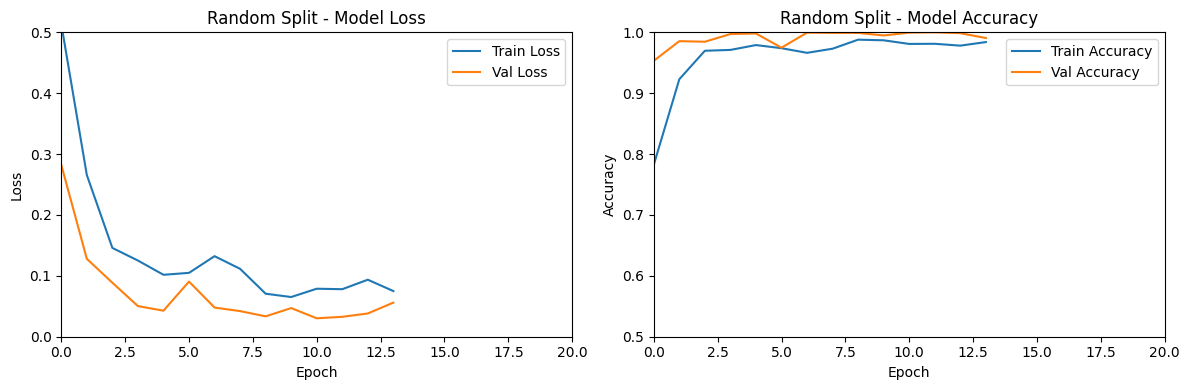

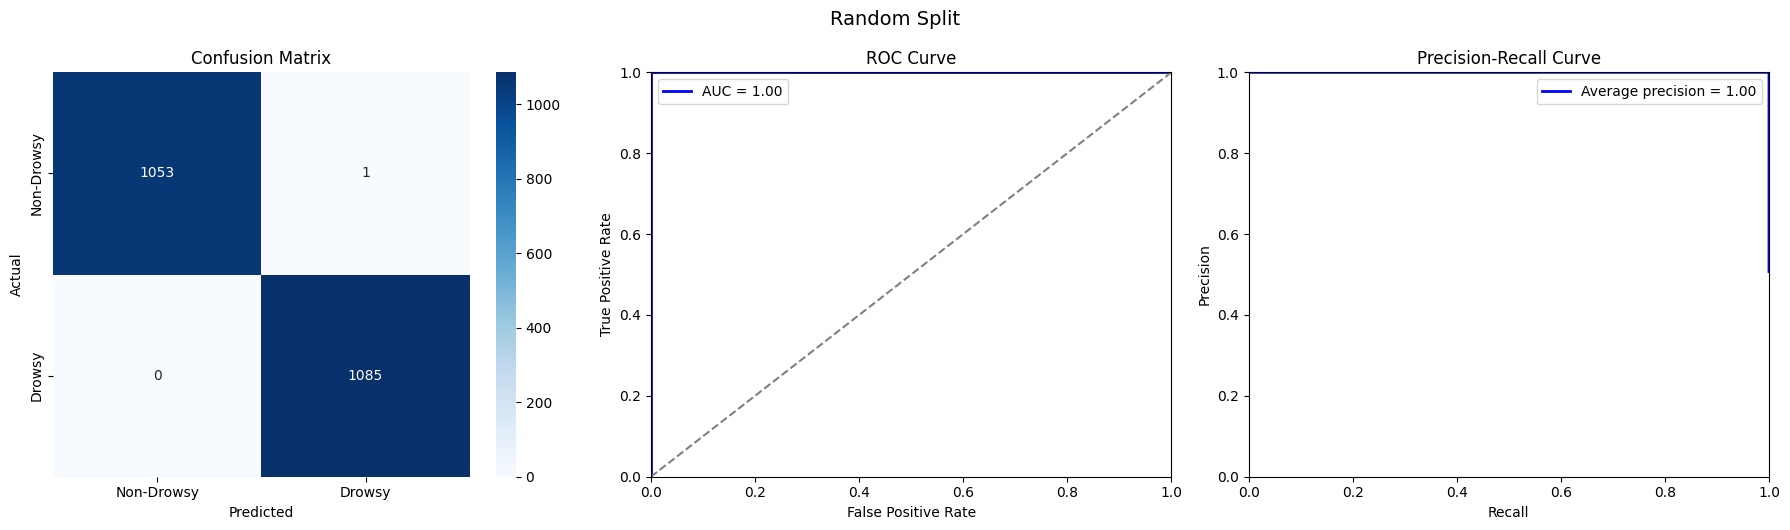


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1054
         1.0       1.00      1.00      1.00      1085

    accuracy                           1.00      2139
   macro avg       1.00      1.00      1.00      2139
weighted avg       1.00      1.00      1.00      2139

CPU times: user 11min 37s, sys: 1min 55s, total: 13min 33s
Wall time: 13min 5s


In [ ]:
%%time
train_and_evaluate(model, X_train, X_test, y_train, y_test, title, best_model_name)

Verify with CNN + LSTM Model (Subject-Wise Split):

In [ ]:
# Train the model based on subject-wise split
X_train, X_test, y_train, y_test = load_saved_sequences(split_type="subject")

✅ Loaded subject split
X_train shape: (8434, 30, 96, 96, 1)
y_train shape: (8434,)
X_test shape: (2260, 30, 96, 96, 1)
y_test shape: (2260,)


In [ ]:
title = "Subject-wise Split"
best_model_name = "best_model_subject_wise.keras"

Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 54s 204ms/step - accuracy: 0.9873 - loss: 0.0610 - val_accuracy: 0.9907 - val_loss: 0.0412
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 50s 189ms/step - accuracy: 0.9917 - loss: 0.0452 - val_accuracy: 0.9876 - val_loss: 0.0656
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 50s 189ms/step - accuracy: 0.9926 - loss: 0.0412 - val_accuracy: 0.9748 - val_loss: 0.0721
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 50s 189ms/step - accuracy: 0.9911 - loss: 0.0471 - val_accuracy: 0.9814 - val_loss: 0.0853
Subject-wise Split - Test Accuracy: 0.9907 | Test Loss: 0.0412
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


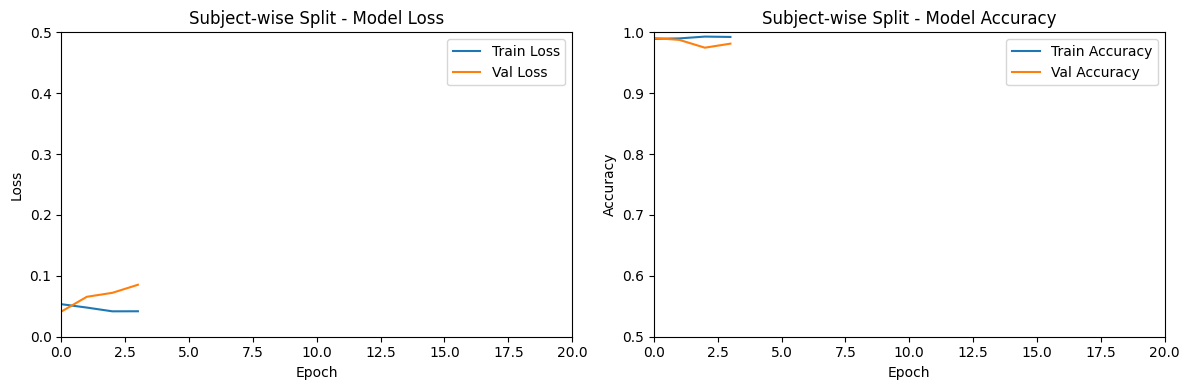

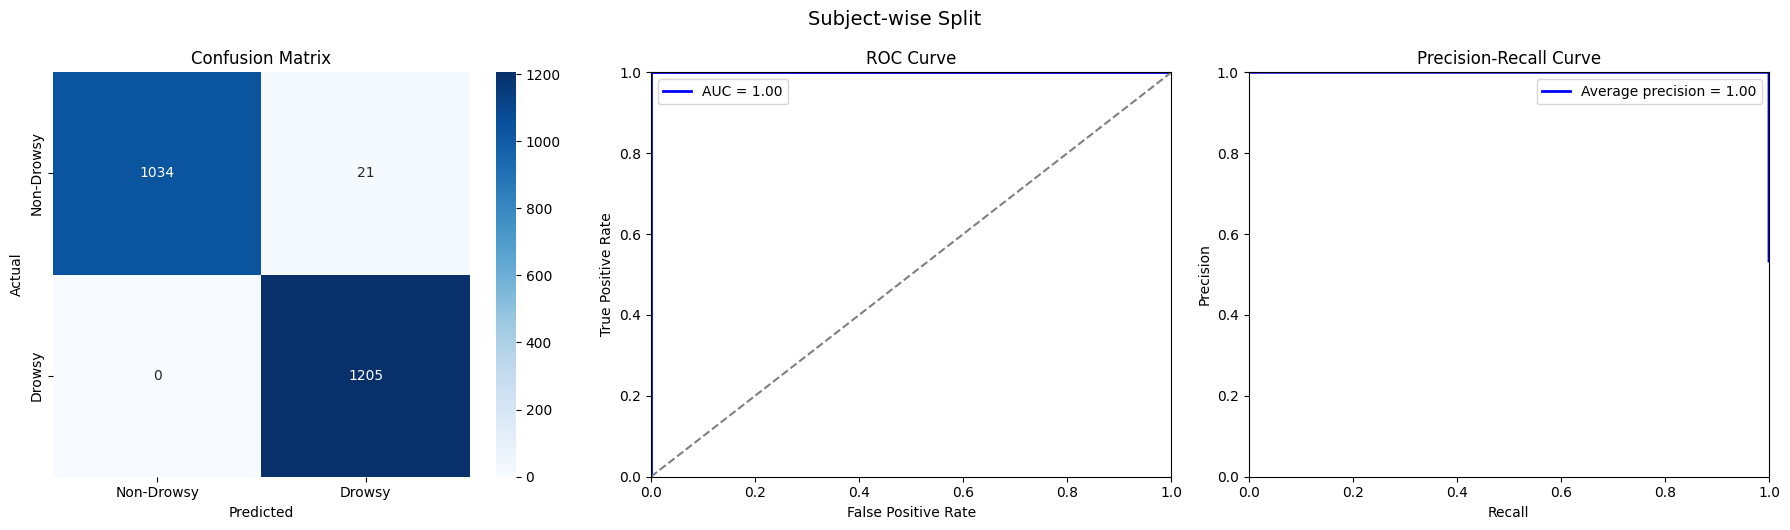


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1055
         1.0       0.98      1.00      0.99      1205

    accuracy                           0.99      2260
   macro avg       0.99      0.99      0.99      2260
weighted avg       0.99      0.99      0.99      2260

CPU times: user 3min 17s, sys: 31.9 s, total: 3min 49s
Wall time: 3min 41s


In [ ]:
%%time
train_and_evaluate(model, X_train, X_test, y_train, y_test, title, best_model_name)